# Local and Global Differential Privacy

In [1]:
import sys
sys.path.append("..") # add parent directory to path
from common import *

In [2]:
import torch

## Project: Local Differential Privacy
As you can see, the basic sum query is not differentially private at all! In truth, differential privacy always requires a form of randomness added to the query. Let me show you what I mean.

### Randomized Response (Local Differential Privacy)
Let's say I have a group of people I wish to survey about a very taboo behavior which I think they will lie about (say, I want to know if they have ever committed a certain kind of crime). I'm not a policeman, I'm just trying to collect statistics to understand the higher level trend in society. So, how do we do this? One technique is to add randomness to each person's response by giving each person the following instructions (assuming I'm asking a simple yes/no question):

- Flip a coin 2 times.
- If the first coin flip is heads, answer honestly
- If the first coin flip is tails, answer according to the second coin flip (heads for yes, tails for no)!

Thus, each person is now protected with "plausible deniability". If they answer "Yes" to the question "have you committed X crime?", then it might becasue they actually did, or it might be becasue they are answering according to a random coin flip. Each person has a high degree of protection. Furthermore, we can recover the underlying statistics with some accuracy, as the "true statistics" are simply averaged with a 50% probability. Thus, if we collect a bunch of samples and it turns out that 60% of people answer yes, then we know that the TRUE distribution is actually centered around 70%, because 70% averaged wtih 50% (a coin flip) is 60% which is the result we obtained.

However, it should be noted that, especially when we only have a few samples, this comes at the cost of accuracy. This tradeoff exists across all of Differential Privacy. The greater the privacy protection (plausible deniability) the less accurate the results.

Let's implement this local DP for our database before!

In [3]:
def get_augment_db(db, noise=0.5):
    """
    Return an augmented db with the 2 coin flip strategy
    """
    p_head = 1 - noise
    noise_db = db.clone().float()
    num_entries = len(db)
    flip_no1 = (torch.rand(num_entries) < p_head).float()
    flip_no2 = (torch.rand(num_entries) < 0.5).float() # 2nd flip is always 50 50
    # if the first coin is head, answer honestly -> Keep db at indices where flip_no1 == 1
    # else, return the value of the second coin  -> Replace db at indices leftover
    # insort, we copy flip_no2 to db at indices where flip_no1 is tail
    noise_db[flip_no1 != 1] = flip_no2[flip_no1 != 1]
    return noise_db
    
    
def reverse_actual_percentage(augmented_percentage, noise=0.5) -> float:
    """
    Average the actual positive of the population, given the query result and
    probability of flipping a head (See more on README.md) 
    """
    p_head = 1 - noise
    return (augmented_percentage - (1 - p_head) * 0.5) / p_head
    

In [4]:
def query(db):
    return db.float().mean()

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
num_test = 1000
list_num_entries = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
mean_arr = []

for num_entries in list_num_entries:
    db = (torch.rand(int(num_entries)) > 0.5).float()
    actual_mean = torch.mean(db)
    differ = []
    for _ in range(num_test):
        aug_db = get_augment_db(db)
        aug_mean = reverse_actual_percentage(torch.mean(aug_db))
        d = torch.abs(aug_mean - actual_mean)
        differ.append(d.item())
    mean_arr.append(differ)
    

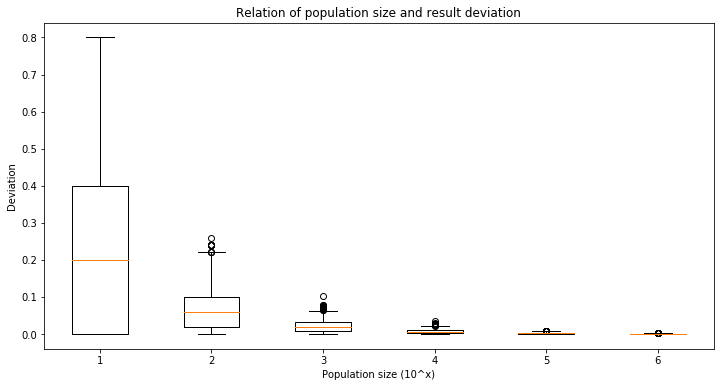

In [7]:
plt.figure(figsize=(12, 6))
plt.title("Relation of population size and result deviation")
plt.boxplot(mean_arr)
plt.xlabel("Population size (10^x)")
plt.ylabel("Deviation")
plt.savefig("relation1.png", dpi=200)
plt.show()

We can see that when the **population size increase**, Population's actual mean and augmented mean are getting **closer**

## Project: Varying Amounts of Noise
In this project, I want you to **augment the randomized response query** (the one we just wrote) to allow for varying amounts of randomness to be added. Specifically, I want you to **bias the first coin flip** to be higher or lower and then run the same experiment.

Note - this one is a bit tricker than you might expect. You need to both adjust the likelihood of the first coin flip AND the de-skewing at the end (where we create the "augmented_result" variable).

My code still work fine :D

In [8]:
def get_differ_distribution(num_entries, list_noise=[0.1, 0.3, 0.5, 0.7, 0.9]):
    """
    Generate List[List[float]] with each List[float] is the difference of actual mean and
    average mean which is calculated from augmented mean
    """
    # Generate DB
    db = (torch.rand(num_entries) > 0.5).float()
    actual_mean = query(db)
    result = []
    for noise in list_noise:
        query_differ = []
        for _ in range(num_test):
            aug_db = get_augment_db(db, noise)
            aug_mean = query(aug_db)
            aug_mean = reverse_actual_percentage(aug_mean, noise)
            query_differ.append(torch.abs(actual_mean - aug_mean).item())
        result.append(query_differ)
    return result

    
def plot_box(num_entries, result, list_noise):
#     plt.figure(figsize=(6, 10))
    plt.title(f"Relation of noise and deviation (N = {num_entries})")
    plt.boxplot(result)
    num_noise = len(list_noise)
    plt.xticks(ticks=range(1, num_noise + 1), labels=list_noise)
    plt.xlabel("Noise")
    plt.ylabel("Difference")


In [9]:
list_noise = [0.1, 0.3, 0.5, 0.7, 0.9]
num_entries = 1000
res1000 = get_differ_distribution(num_entries, list_noise)

In [10]:
list_noise = [0.1, 0.3, 0.5, 0.7, 0.9]
num_entries = 100000
res100000 = get_differ_distribution(num_entries, list_noise)

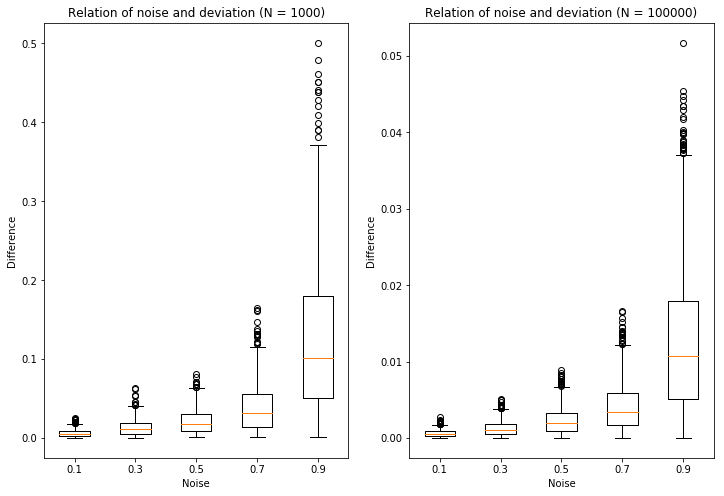

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plot_box(1000, res1000, list_noise)
plt.subplot(1, 2, 2)
plot_box(100000, res100000, list_noise)
plt.savefig("relation2.png", dpi=200)

Beside the exponential increment of deviation when noise increase, we can see that when the population increase, the deviation is getting smaller. 